In [65]:
import pandas as pd
import os
import re
import tarfile
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tqdm
from concurrent.futures import ThreadPoolExecutor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

ModuleNotFoundError: No module named 'numpy.char'

### File Prep - First Time

In [14]:
tar_path = './data/UNGDC_1946-2023.tgz'
extract_path = './data/UNGDC_1946-2023/'

with tarfile.open(tar_path, 'r:gz') as tar:
    tar.extractall(path=extract_path)

### Data Import

In [ ]:
vdem_df = pd.read_csv('./data/V-Dem-CY-Full+Others-v14.csv')

C:\Users\maxla\AppData\Local\Temp\ipykernel_48352\952016332.py:1: DtypeWarning: Columns (364,365,366,399,415,804,836,837,924,1240,1257,1486,3094,3168,3169,3341,3342,3344,3345,3347,3350,3352) have mixed types. Specify dtype option on import or set low_memory=False.
  vdem_df = pd.read_csv('./data/V-Dem-CY-Full+Others-v14.csv')


In [7]:
print(vdem_df.head())
print(vdem_df.info())

  country_name country_text_id  country_id  year historical_date  project  \
0       Mexico             MEX           3  1789      1789-12-31        1   
1       Mexico             MEX           3  1790      1790-12-31        1   
2       Mexico             MEX           3  1791      1791-12-31        1   
3       Mexico             MEX           3  1792      1792-12-31        1   
4       Mexico             MEX           3  1793      1793-12-31        1   

   historical                  histname  codingstart  codingend  ...  \
0           1  Viceroyalty of New Spain         1789       2023  ...   
1           1  Viceroyalty of New Spain         1789       2023  ...   
2           1  Viceroyalty of New Spain         1789       2023  ...   
3           1  Viceroyalty of New Spain         1789       2023  ...   
4           1  Viceroyalty of New Spain         1789       2023  ...   

   e_mipopula  e_miurbani  e_pefeliex  e_wb_pop  e_pechmor  e_miinteco  \
0         NaN         NaN     

In [20]:
base_dir = './data/UNGDC_1946-2023/TXT'

speeches = []

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith('.txt'):
            # The expected naming pattern is: COUNTRY_SESSION_YEAR.txt
            # e.g., USA_75_2020.txt
            match = re.match(r"([A-Z]{3})_(\d{1,3})_(\d{4})\.txt", file)
            if match:
                country, session, year = match.groups()
            else:
                continue

            file_path = os.path.join(root, file)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    text = f.read()
            except UnicodeDecodeError as e:
                print(f"Decoding error in {file_path}: {e}")
                continue

            speeches.append({
                'Country': country,
                'Session': int(session),
                'Year': int(year),
                'Text': text,
            })

df_speeches = pd.DataFrame(speeches)
print(df_speeches.head())

  Country  Session  Year                                               Text
0     ARG        1  1946  At the resumption of the first session of the ...
1     AUS        1  1946  The General Assembly of the United Nations is ...
2     BEL        1  1946  The\tprincipal organs of the United Nations ha...
3     BLR        1  1946  As more than a year has elapsed since the Unit...
4     BOL        1  1946  Coming to this platform where so many distingu...


In [24]:
df_speeches['Year'] = df_speeches['Year'].astype(int)
vdem_df['year'] = vdem_df['year'].astype(int)

In [35]:
df = pd.merge(
    df_speeches,
    vdem_df,
    left_on=['Country', 'Year'],
    right_on=['country_text_id', 'year'],
    how='left'
)

# Please note that there are some NaN in the year etc (about 40 for year). See if is issue?

### Data Clearning/Eng

In [42]:
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

### EDA

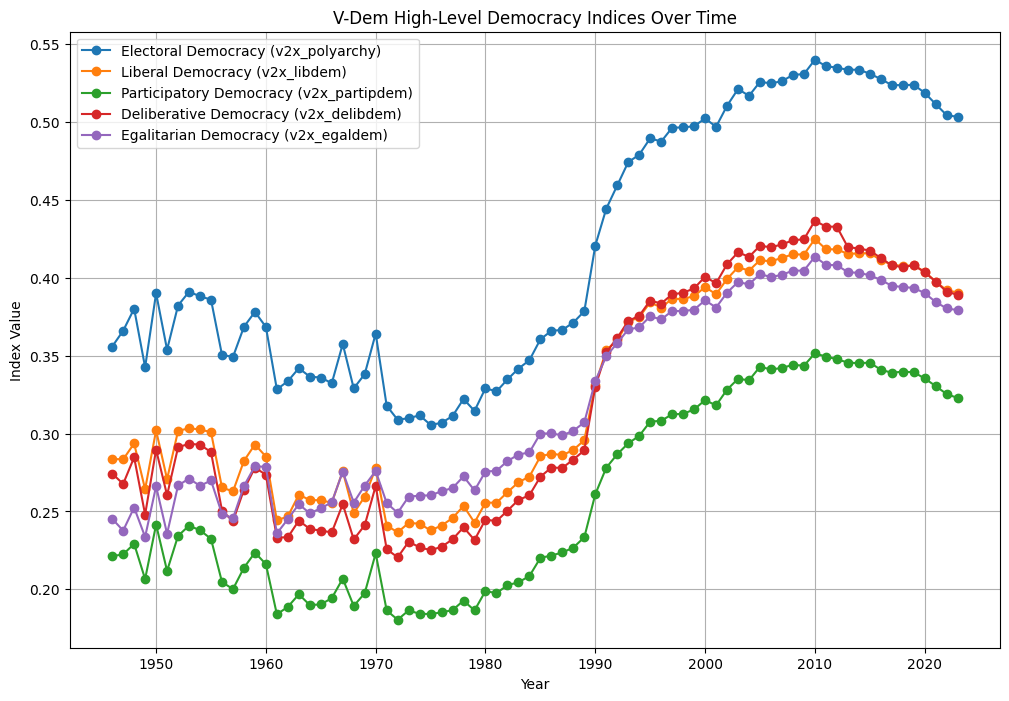

In [43]:
indices = {
    'Electoral Democracy (v2x_polyarchy)': 'v2x_polyarchy',
    'Liberal Democracy (v2x_libdem)': 'v2x_libdem',
    'Participatory Democracy (v2x_partipdem)': 'v2x_partipdem',
    'Deliberative Democracy (v2x_delibdem)': 'v2x_delibdem',
    'Egalitarian Democracy (v2x_egaldem)': 'v2x_egaldem'
}

df_yearly = df.groupby('Year')[list(indices.values())].mean().reset_index()

plt.figure(figsize=(12, 8))

for label, col in indices.items():
    plt.plot(df_yearly['Year'], df_yearly[col], marker='o', label=label)

plt.xlabel('Year')
plt.ylabel('Index Value')
plt.title('V-Dem High-Level Democracy Indices Over Time')
plt.legend()
plt.grid(True)
plt.show()

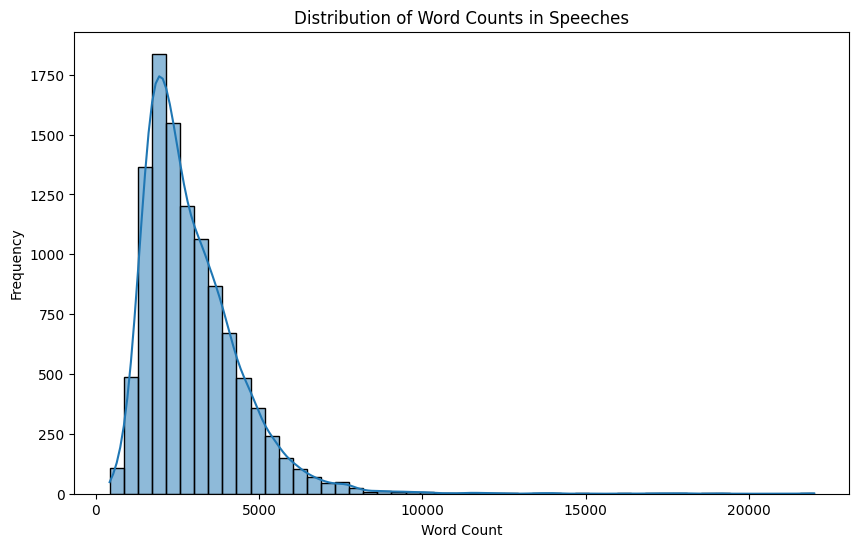

In [44]:
df['word_count'] = df['Text'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Distribution of Word Counts in Speeches")
plt.show()

100%|██████████| 10747/10747 [01:57<00:00, 91.33it/s] 


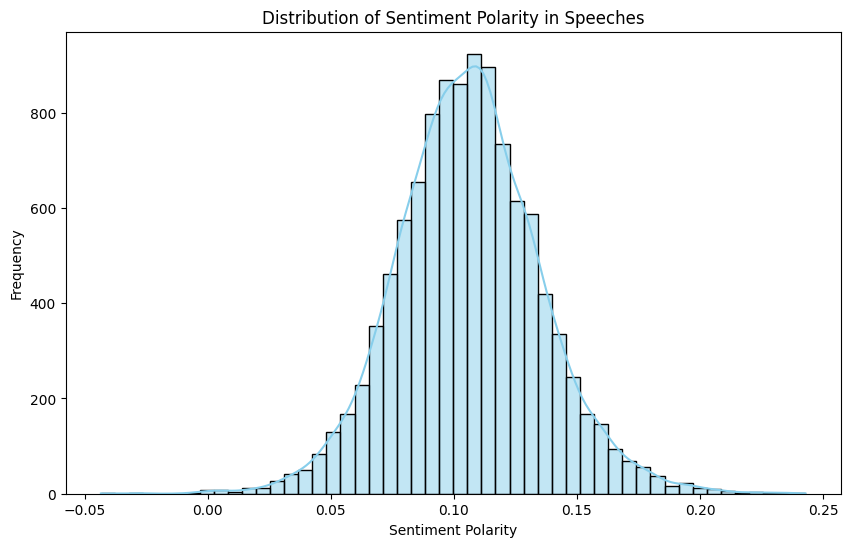

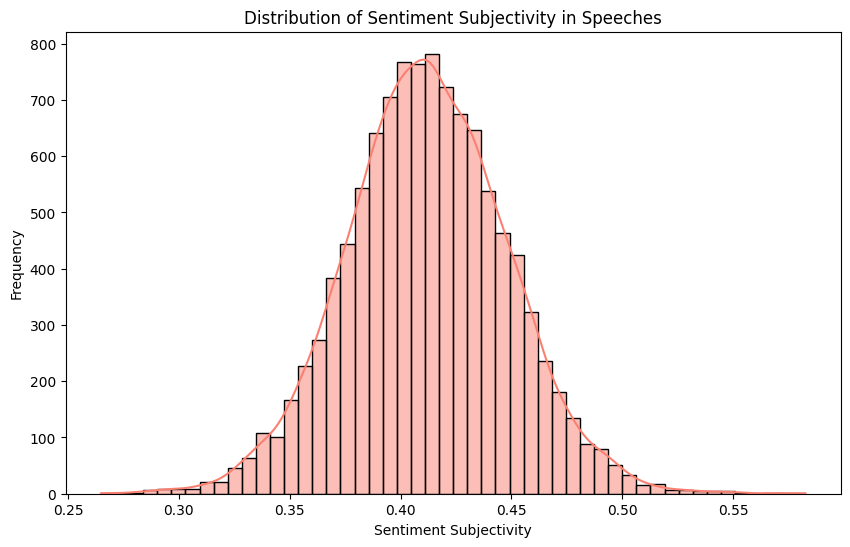

In [54]:
def compute_sentiment(text):
    try:
        text = str(text)
        blob = TextBlob(text)
        return blob.sentiment.polarity, blob.sentiment.subjectivity
    except Exception as e:
        print(f"Error in processing text: {e}")
        return 0.0, 0.0

texts = df['Text'].tolist()

with ThreadPoolExecutor() as executor:
    results = list(tqdm.tqdm(executor.map(compute_sentiment, texts), total=len(texts)))

polarities, subjectivities = zip(*results)

# Plot the distribution of sentiment polarity
plt.figure(figsize=(10, 6))
sns.histplot(polarities, bins=50, kde=True, color='skyblue')
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiment Polarity in Speeches")
plt.show()

# Plot the distribution of sentiment subjectivity
plt.figure(figsize=(10, 6))
sns.histplot(subjectivities, bins=50, kde=True, color='salmon')
plt.xlabel("Sentiment Subjectivity")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiment Subjectivity in Speeches")
plt.show()

In [62]:
temp_df = df.copy()
temp_df['sentiment_polarity'] = polarities 
temp_df['sentiment_subjectivity'] = subjectivities

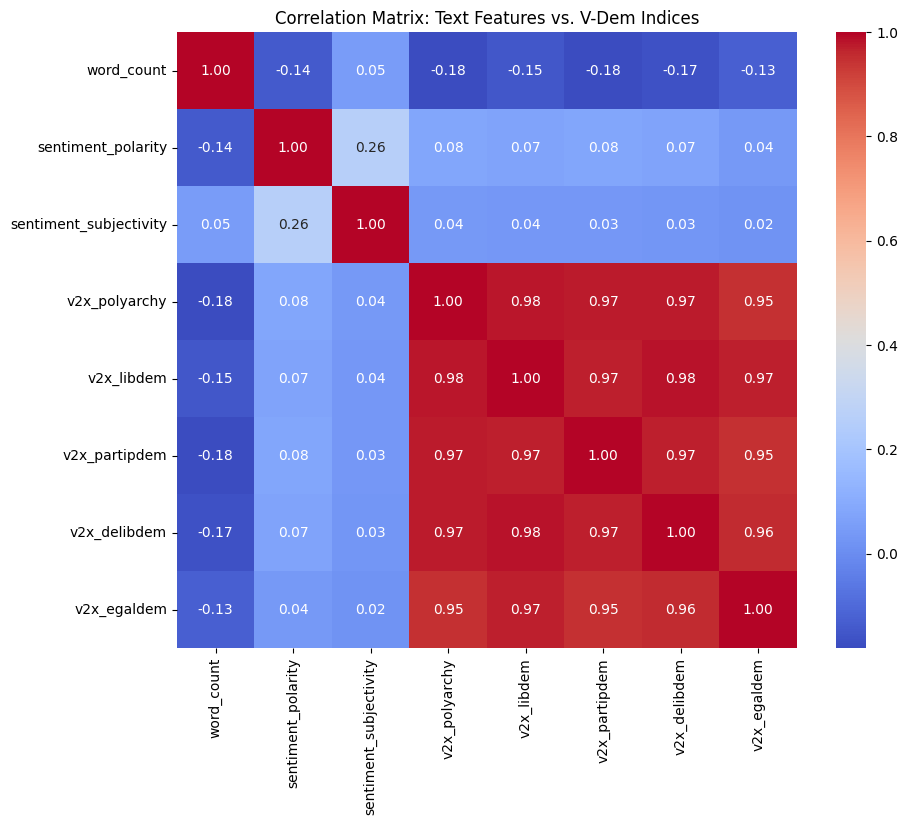

In [63]:
selected_cols = [
    'word_count', 
    'sentiment_polarity', 
    'sentiment_subjectivity', 
    'v2x_polyarchy',      # Electoral democracy index
    'v2x_libdem',         # Liberal democracy index
    'v2x_partipdem',      # Participatory democracy index
    'v2x_delibdem',       # Deliberative democracy index
    'v2x_egaldem'         # Egalitarian democracy index
]

# Compute the correlation matrix for these columns.
corr_matrix = temp_df[selected_cols].corr()

# Plot the correlation heatmap.
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Text Features vs. V-Dem Indices")
plt.show()